<a href="https://colab.research.google.com/github/sancarhacer/MachineLearning/blob/main/LogisticRegressionAdvanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("8-fraud_detection.csv")
df.columns

Index(['transaction_amount', 'transaction_risk_score', 'is_fraud'], dtype='object')

In [3]:
df["is_fraud"].value_counts()

,count
is_fraud,
0,9846
1,154


In [4]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

In [5]:
X.head()

,transaction_amount,transaction_risk_score
0,1.879910,-1.485035
1,0.377083,-2.238585
2,1.354312,-2.664638
3,-0.509843,-1.502950
4,0.863561,-1.906364


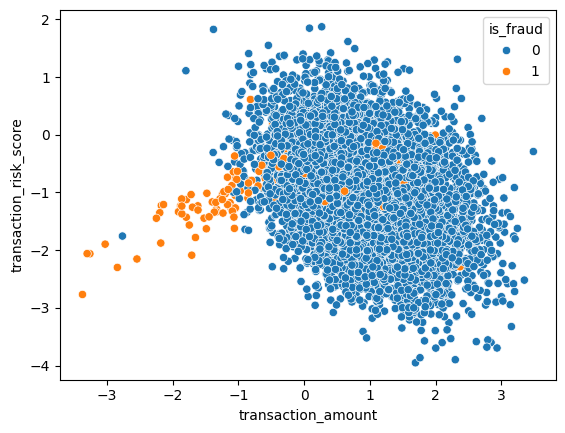

In [6]:
sns.scatterplot(x=X['transaction_amount'],y=X['transaction_risk_score'], hue=y)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=15)

In [8]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()


In [9]:
#hyperparameter tuning with class weights to handle imbalance
penalty=['l1', 'l2', 'elasticnet']
c_values=[100,10,1.0,0.1,0.01]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight=[{0:w,1:y} for w in [1,10,50,100] for y in [1,10,50,100]]

In [10]:
class_weight

[{0: 1, 1: 1},
 {0: 1, 1: 10},
 {0: 1, 1: 50},
 {0: 1, 1: 100},
 {0: 10, 1: 1},
 {0: 10, 1: 10},
 {0: 10, 1: 50},
 {0: 10, 1: 100},
 {0: 50, 1: 1},
 {0: 50, 1: 10},
 {0: 50, 1: 50},
 {0: 50, 1: 100},
 {0: 100, 1: 1},
 {0: 100, 1: 10},
 {0: 100, 1: 50},
 {0: 100, 1: 100}]

In [11]:
params  = dict(penalty=penalty,C=c_values,solver=solver,class_weight=class_weight)

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [13]:
cv = StratifiedKFold()

In [14]:
grid=GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=cv)

In [15]:
import warnings
warnings.filterwarnings('ignore')
grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 50}, {0: 1, 1: 100},
                                          {0: 10, 1: 1}, {0: 10, 1: 10},
                                          {0: 10, 1: 50}, {0: 10, 1: 100},
                                          {0: 50, 1: 1}, {0: 50, 1: 10},
                                          {0: 50, 1: 50}, {0: 50, 1: 100},
                                          {0: 100, 1: 1}, {0: 100, 1: 10},
                                          {0: 100, 1: 50}, {0: 100, 1: 100}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [16]:
grid.best_params_

{'C': 0.01,
 'class_weight': {0: 10, 1: 50},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [17]:
y_pred=grid.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
score=accuracy_score(y_pred,y_test)
print("score: ", score)
print(classification_report(y_pred,y_test))
print("confusion matrix: \n " , confusion_matrix(y_pred,y_test))

score:  0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2481
           1       0.42      0.84      0.56        19

    accuracy                           0.99      2500
   macro avg       0.71      0.92      0.78      2500
weighted avg       0.99      0.99      0.99      2500

confusion matrix: 
  [[2459   22]
 [   3   16]]


## roc, auc
The ROC Curve is a graphical representation of a classification model’s performance across different threshold values. It plots the True Positive Rate (Recall) on the Y-axis against the False Positive Rate (1 - Specificity) on the X-axis. • A model that perfectly distinguishes between classes has a curve that reaches the top-left corner. • The closer the curve is to the top-left, the better the model. • The area under the ROC curve (AUC) quantifies this performance: • AUC = 1 → perfect classifier • AUC = 0.5 → random guessing

ROC is especially useful for imbalanced datasets, as it evaluates the model independent of class distribution or threshold.

In [19]:
# predict_proba returns two probability values for each test sample:
# [0] → probability of belonging to the negative class
# [1] → probability of belonging to the positive class

model_prob = grid.predict_proba(X_test)
model_prob


array([[0.99586436, 0.00413564],
       [0.85287009, 0.14712991],
       [0.952308  , 0.047692  ],
       ...,
       [0.98898975, 0.01101025],
       [0.98454137, 0.01545863],
       [0.99758734, 0.00241266]])

In [20]:
##  probabilities for the positive class
# Here, only the probabilities for the positive class (1) are selected.
# This is because ROC-AUC is typically calculated using the probabilities of the positive class.

model_prob=model_prob[:,1]

In [21]:
# roc_auc_score calculates the area under the ROC curve (AUC).
# Result: 0.739 → The model's ability to distinguish between classes is around 73%.
from sklearn.metrics import roc_auc_score
model_auc = roc_auc_score(y_test, model_prob)
model_auc

np.float64(0.7392898371029116)

In [22]:
# roc_curve calculates the False Positive Rate (FPR) and True Positive Rate (TPR)
# for different threshold values.
# Threshold = 0.5 → This is the default decision point (if probability ≥ 0.5, we classify as "positive").
# For the ROC curve, the threshold is varied continuously from 1 to 0,
# and TPR and FPR values are computed for each threshold.
# The 'thresholds' output shows different probability cutoffs
# (e.g., 0.93, 0.55, 0.31, 0.08, etc.).
# For each threshold, the model's TPR and FPR are recalculated.

from sklearn.metrics import roc_curve
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_prob)
thresholds


array([           inf, 9.30437623e-01, 5.77439071e-01, 5.43503126e-01,
       5.36071177e-01, 3.13930014e-01, 3.13113053e-01, 2.63811756e-01,
       2.62153759e-01, 1.82293113e-01, 1.81413613e-01, 1.81238368e-01,
       1.81099479e-01, 1.40639443e-01, 1.40466934e-01, 8.37807931e-02,
       8.36475387e-02, 6.24145598e-02, 6.23568050e-02, 5.87450606e-02,
       5.85760393e-02, 4.66734882e-02, 4.66388457e-02, 4.44079179e-02,
       4.44070020e-02, 3.15450104e-02, 3.14979943e-02, 2.58175962e-02,
       2.57789181e-02, 2.53613709e-02, 2.53519752e-02, 2.37938921e-02,
       2.37805419e-02, 1.76180426e-02, 1.75917346e-02, 1.49644153e-02,
       1.49487085e-02, 1.34565240e-02, 1.34207005e-02, 1.10633422e-02,
       1.10295711e-02, 1.02139146e-02, 1.01950346e-02, 9.12485849e-03,
       9.07466070e-03, 8.79584638e-03, 8.78353810e-03, 7.86815504e-03,
       7.85740346e-03, 5.67174629e-04])

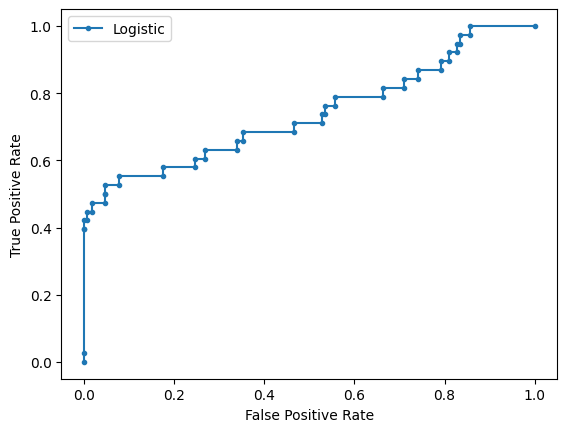

In [24]:
# The closer the curve is to the top-left corner, the better the model.

plt.plot(model_fpr, model_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

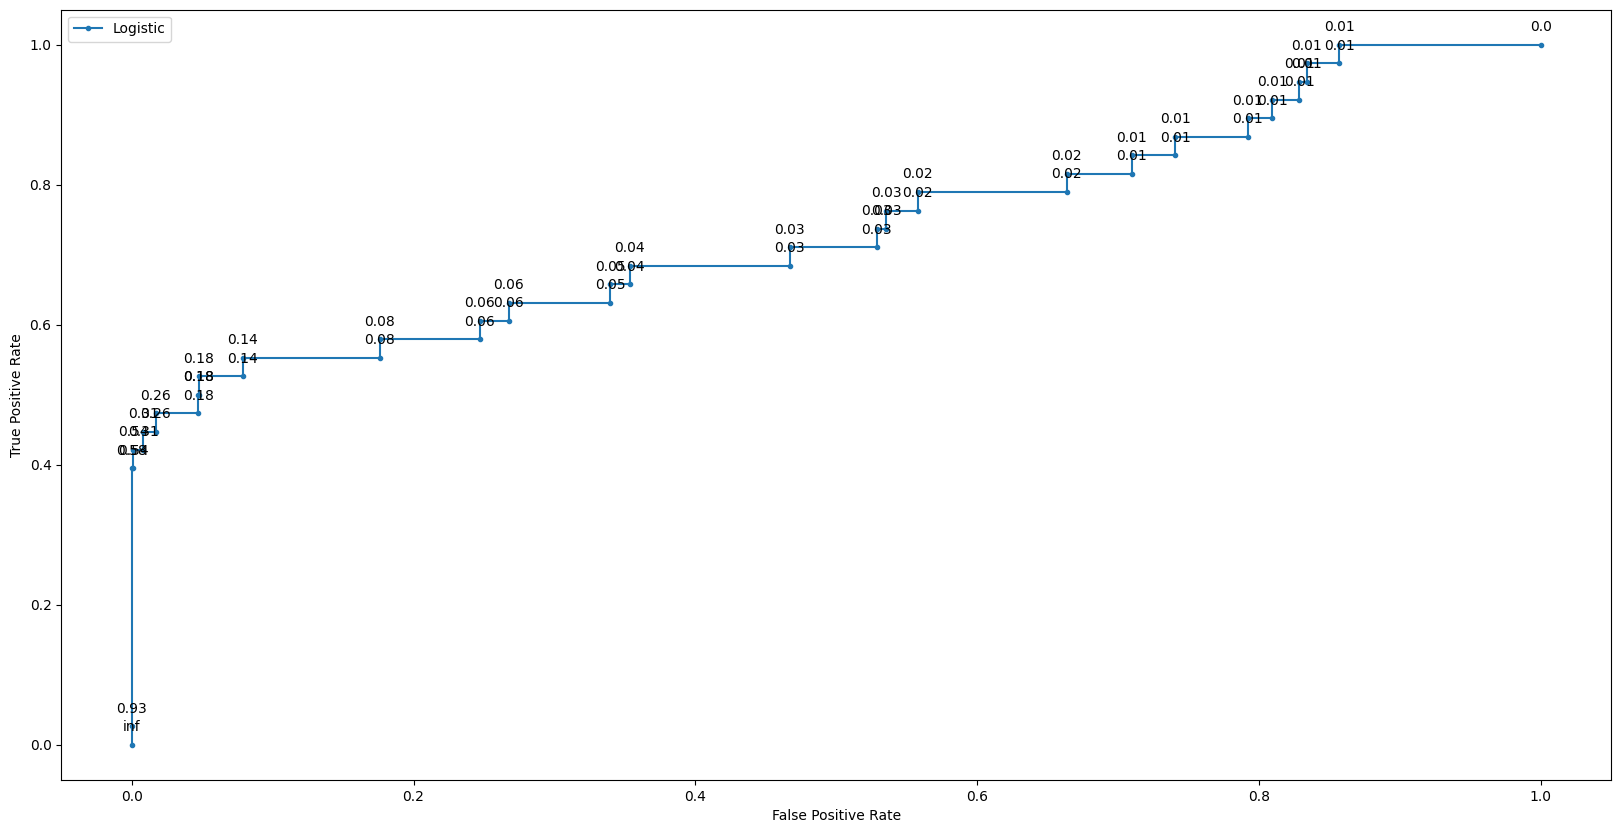

In [26]:
# ax.annotate → added tag each on Grafik
# Create the figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot ROC curve
ax.plot(model_fpr, model_tpr, marker='.', label='Logistic')

# Annotate each point with the threshold
for fpr, tpr, thresh in zip(model_fpr, model_tpr, thresholds):
    ax.annotate(f'{np.round(thresh, 2)}', (fpr, tpr), textcoords="offset points", xytext=(0,10), ha='center')

# Labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show the plot
plt.show()